In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Check device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 2. Data Loading and Exploration

In [4]:
pwd

'E:\\RMIT\\Fourth-Semester\\Computational-MachineLearning\\Assignment-2\\ColonCancer-Classification-Project\\notebooks'

In [10]:

# Paths to your CSV files
main_labels_path = '../data/data_labels_mainData.csv'  # Adjust this based on where you store it
extra_labels_path = '../data/data_labels_extraData.csv'

# Load the CSVs
main_df = pd.read_csv(main_labels_path)
extra_df = pd.read_csv(extra_labels_path)

# Display the first few rows
print("Main Data Labels:")
display(main_df.head())

print("\nExtra Data Labels:")
display(extra_df.head())


Main Data Labels:


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0



Extra Data Labels:


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [11]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [12]:
# Check class balance in Main Data
print("isCancerous Distribution in Main Data:")
print(main_df['isCancerous'].value_counts())

print("\ncellType Distribution in Main Data:")
print(main_df['cellType'].value_counts())

# Check class balance in Extra Data
print("\nisCancerous Distribution in Extra Data:")
print(extra_df['isCancerous'].value_counts())



isCancerous Distribution in Main Data:
isCancerous
0    5817
1    4079
Name: count, dtype: int64

cellType Distribution in Main Data:
cellType
2    4079
1    2543
0    1888
3    1386
Name: count, dtype: int64

isCancerous Distribution in Extra Data:
isCancerous
0    7394
1    2990
Name: count, dtype: int64


# import matplotlib.pyplot as plt

# # Plot isCancerous distribution
# main_df['isCancerous'].value_counts().plot(kind='bar')
# plt.title('isCancerous Label Distribution')
# plt.xlabel('Class')
# plt.ylabel('Number of Samples')
# plt.show()

# # Plot cellType distribution
# main_df['cellType'].value_counts().plot(kind='bar')
# plt.title('cellType Label Distribution')
# plt.xlabel('Cell Type')
# plt.ylabel('Number of Samples')
# plt.show()


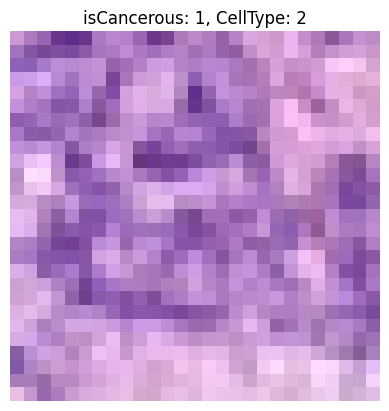

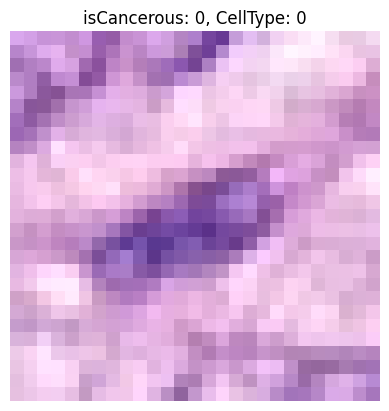

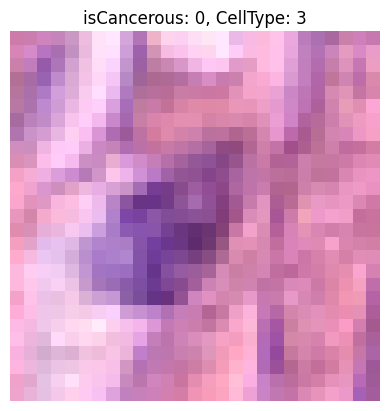

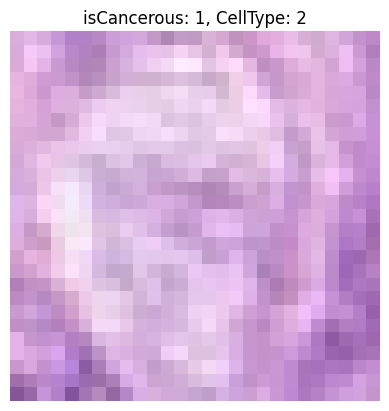

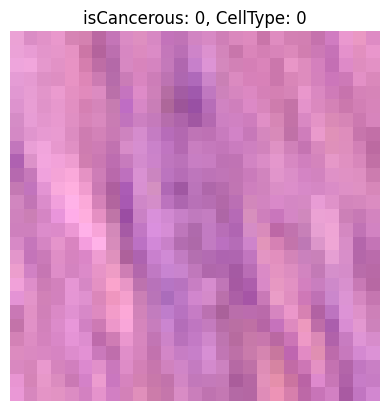

In [17]:
# Sample Image Folder
image_folder = '../data/patch_images/'  # Adjust path as needed

# Display a few random samples
sample_images = main_df.sample(5)  # Randomly pick 5 images

for idx, row in sample_images.iterrows():
    img_path = os.path.join(image_folder, row['ImageName'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"isCancerous: {row['isCancerous']}, CellType: {row.get('cellType', 'N/A')}")
    plt.axis('off')
    plt.show()


**Preprocessing Notes:**

- **Image Size:** All images are 27x27 RGB, no resizing needed.
- **Normalization:** Apply transforms.ToTensor() followed by transforms.Normalize((0.5,), (0.5,)) to scale pixel values to [-1,1] for better CNN performance.
- **Label Encoding:** 
  - For Task 1 (Cancer detection): Use the `isCancerous` binary label (0/1).
  - For Task 2 (Cell type classification): Encode string cell types into integer classes.
- **Data Splitting:** Dataset will be split into 70% training, 15% validation, 15% testing, stratified by `isCancerous` labels to preserve class balance.
- **Additional Observations:** Dataset shows slight class imbalance (e.g., more epithelial cells), but manageable without aggressive augmentation initially.


# 3. Data Preprocessing


## 3.1 Image Transformations (Preprocessing)

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),                 # PIL Image -> Tensor, and scales [0,255] to [0,1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize [0,1] → [-1,1]
])

## 3.2 Create a Custom PyTorch Dataset Class

In [19]:
class ColonCancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, task='cancer'):
        self.dataframe = dataframe           # DataFrame with labels
        self.img_dir = img_dir                # Folder where images are stored
        self.transform = transform            # Any transforms (e.g., normalize)
        self.task = task                      # 'cancer' (binary) or 'celltype' (multi-class)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get label
        if self.task == 'cancer':
            label = torch.tensor(self.dataframe.iloc[idx]['isCancerous'], dtype=torch.float32)
        elif self.task == 'celltype':
            label = torch.tensor(self.dataframe.iloc[idx]['cellTypeEncoded'], dtype=torch.long)
        
        return image, label


## Train/Validation/Test Split

In [21]:
# Split the main_df into train/validation/test
train_df, temp_df = train_test_split(main_df, test_size=0.3, stratify=main_df['isCancerous'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['isCancerous'], random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 6927
Validation set size: 1484
Test set size: 1485
